In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [169]:
def eu_call_price(S0, K, T, r, sigma):
    d_plus = 1/(sigma * np.sqrt(T)) * (np.log(S0/K) + (r + 0.5*sigma**2)*T)
    d_minus = d_plus - sigma * np.sqrt(T)
    C = norm.cdf(d_plus) * S0 - norm.cdf(d_minus) * K * np.exp(-r * T)
    return C

def eu_option_price(S0, K, T, r, sigma):
    C = eu_call_price(S0, K, T, r, sigma)
    P = K * np.exp(-r*T) - S0 + C
    return [C, P]


def geometric_asian_option_price(S0, K, T, r, sigma):
    sigma_g = sigma / np.sqrt(3)
    mu_g = 0.5 * r - (sigma ** 2) / 6

    d1 = (np.log(S0 / K) + (mu_g + 0.5 * sigma_g ** 2) * T) / (sigma_g * np.sqrt(T))
    d2 = d1 - sigma_g * np.sqrt(T)

    discounted = np.exp(-r * T)
    forward_S = S0 * np.exp(mu_g * T)

    call = discounted * (forward_S * norm.cdf(d1) - K * norm.cdf(d2))
    put = discounted * (K * norm.cdf(-d2) - forward_S * norm.cdf(-d1))

    return call, put


def geometric_brownian_motion(S0, sigma, r, T, N=1000, M=1000, antithetic=True):
    """Simulate M trials, each of N timesteps of size T/N each """
    dt = T / N
    M = M // 2 if antithetic else M
    W = np.random.randn(M, N-1)
    
    paths = np.zeros((M, N))
    paths[:, 0] = S0
    paths[:, 1:] = S0 * np.exp((r - sigma ** 2 / 2) * dt * np.cumsum(np.ones((M, N-1)), axis=1) +
                      sigma * np.sqrt(dt) * np.cumsum(W, axis=1))
    if antithetic:
        paths_antithetic = np.zeros((M, N))
        paths_antithetic[:, 0] = S0
        paths_antithetic[:, 1:] = S0 * np.exp((r - sigma ** 2 / 2) * dt * np.cumsum(np.ones((M, N-1)), axis=1) +
                      sigma * np.sqrt(dt) * np.cumsum(-W, axis=1))
        paths = np.vstack((paths, paths_antithetic))

    return paths


def MC_options(S0, K, T, r, sigma, N=1000, M=1000, option_type='european', antithetic=True):
    """
    N: Number of timesteps
    M: Number of trials
    """
    discount_factor = np.exp(-r*T)

    S_paths = geometric_brownian_motion(S0, sigma, r, T, N, M,
                                      antithetic=antithetic)

    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
    
    call_payoffs = np.maximum(S_terminal - K, 0)
    put_payoffs = np.maximum(K - S_terminal, 0)
    call_price = discount_factor * np.mean(call_payoffs)
    put_price = discount_factor * np.mean(put_payoffs) 

    call_std_error = np.std(call_payoffs, ddof=1)/np.sqrt(N)
    put_std_error = np.std(put_payoffs, ddof=1)/np.sqrt(N)
    call_CI = (call_price - 1.96 * call_std_error, call_price + 1.96 * call_std_error)
    put_CI = (put_price - 1.96 * put_std_error, put_price + 1.96 * put_std_error)

    return [call_price, call_CI], [put_price, put_CI]

def MC_call_options(S0, K, T, r, sigma, N=1000, M=1000, option_type='european', antithetic=True):
    """
    Monte Carlo simulation for call option pricing.
    
    Returns:
      call_price, call_confidence_interval, and the standard error of the call estimator.
      
    For antithetic variates, the estimator is computed as the average of paired payoffs.
    """
    discount_factor = np.exp(-r * T)
    S_paths = geometric_brownian_motion(S0, sigma, r, T, N, M, antithetic)

    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
    
    call_payoffs = np.maximum(S_terminal - K, 0)
    call_price = discount_factor * np.mean(call_payoffs)
    
    if antithetic:
        # With antithetic variates, group the payoffs into pairs and average each pair.
        n_total = len(call_payoffs)
        # Reshape into (n_total/2, 2)
        paired_payoffs = 0.5 * (call_payoffs[:n_total // 2] + call_payoffs[n_total // 2:])
        effective_n = len(paired_payoffs)
        call_std_error = np.std(paired_payoffs, ddof=1) / np.sqrt(effective_n)
    else:
        n = len(call_payoffs)
        call_std_error = np.std(call_payoffs, ddof=1) / np.sqrt(n)
    
    call_CI = (call_price - 1.96 * call_std_error, call_price + 1.96 * call_std_error)
    return call_price, call_CI, call_std_error

def MC_put_options(S0, K, T, r, sigma, N=1000, M=1000, option_type='european', antithetic=True):
    """
    Monte Carlo simulation for put option pricing.
    
    Returns:
      call_price, call_confidence_interval, and the standard error of the call estimator.
      
    For antithetic variates, the estimator is computed as the average of paired payoffs.
    """
    discount_factor = np.exp(-r * T)
    S_paths = geometric_brownian_motion(S0, sigma, r, T, N, M, antithetic)

    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
    
    put_payoffs = np.maximum(K - S_terminal, 0)
    put_price = discount_factor * np.mean(put_payoffs)
    
    if antithetic:
        # With antithetic variates, group the payoffs into pairs and average each pair.
        n_total = len(put_payoffs)
        # Reshape into (n_total/2, 2)
        paired_payoffs = 0.5 * (put_payoffs[:n_total // 2] + put_payoffs[n_total // 2:])
        effective_n = len(paired_payoffs)
        put_std_error = np.std(paired_payoffs, ddof=1) / np.sqrt(effective_n)
    else:
        n = len(put_payoffs)
        put_std_error = np.std(put_payoffs, ddof=1) / np.sqrt(n)
    
    put_CI = (put_price - 1.96 * put_std_error, put_price + 1.96 * put_std_error)
    return put_price, put_CI, put_std_error

def MC_call_options(
    S0, K, T, r, sigma,
    N=1000, M=1000,
    option_type='european',
    antithetic=True,
    control_variate=False
):
    discount_factor = np.exp(-r * T)
    S_paths = geometric_brownian_motion(S0, sigma, r, T, N, M, antithetic)

    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))

    call_payoffs = np.maximum(S_terminal - K, 0)

    if control_variate and option_type == 'arithmetic':
        geom_path = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
        control_payoffs = np.maximum(geom_path - K, 0)
        geom_analytic, _ = geometric_asian_option_price(S0, K, T, r, sigma)  # call, put

        mean_arith = np.mean(call_payoffs)
        mean_geom  = np.mean(control_payoffs)
        cov_ag     = np.mean(call_payoffs * control_payoffs) - mean_arith * mean_geom
        var_g      = np.mean(control_payoffs**2) - (mean_geom**2)

        # beta = cov_ag / var_g
        beta = 1

        corrected_payoffs = call_payoffs - beta * (control_payoffs - geom_analytic)

        call_payoffs = corrected_payoffs

    if antithetic:
        
        n_total = len(call_payoffs)
        half_n = n_total // 2
        paired_payoffs = 0.5 * (call_payoffs[:half_n] + call_payoffs[half_n:])
        call_price = discount_factor * np.mean(paired_payoffs)
        call_std = np.std(paired_payoffs, ddof=1)
        effective_n = len(paired_payoffs)
    else:
        call_price = discount_factor * np.mean(call_payoffs)
        call_std = np.std(call_payoffs, ddof=1)
        effective_n = len(call_payoffs)

    call_std_error = call_std / np.sqrt(effective_n)
    call_CI = (
        call_price - 1.96 * call_std_error,
        call_price + 1.96 * call_std_error
    )

    return call_price, call_CI, call_std_error


In [148]:
## Verifying geometric Brownian motions and v stack works.
call_option_prices_MC = {}
put_option_prices_MC = {}
option_prices_analytic = {}
S0 = 10; K = 10; r = 0.04; sigma = 0.15; N = 1000; M = 1000
T_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for T in T_range:
    call_option_prices_MC[T], _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                                   option_type='european', antithetic=True)
    option_prices_analytic[T] = eu_option_price(S0, K, T, r, sigma)

print(call_option_prices_MC)
print(option_prices_analytic)

{1: np.float64(0.8137888598912192), 2: np.float64(1.255251313293028), 3: np.float64(1.669370681488069), 4: np.float64(1.9788824317314007), 5: np.float64(2.3954363709796214), 6: np.float64(2.6138184240463835), 7: np.float64(2.8850742694404525), 8: np.float64(3.333259272950538), 9: np.float64(3.5338766021696224), 10: np.float64(3.7265161224474816)}
{1: [np.float64(0.8028599690220721), np.float64(0.4107543605453037)], 2: [np.float64(1.2534786714690398), np.float64(0.48464213533539713)], 3: [np.float64(1.6420130604762528), np.float64(0.5112174276478276)], 4: [np.float64(1.9953586430675871), np.float64(0.5167965327297006)], 5: [np.float64(2.3238248101667383), np.float64(0.5111323409465571)], 6: [np.float64(2.6326878230996122), np.float64(0.4989664337651467)], 7: [np.float64(2.9251048289104347), np.float64(0.4829422434676891)], 8: [np.float64(3.20316854244599), np.float64(0.4646589131829)], 9: [np.float64(3.468372577193496), np.float64(0.4451358379038064)], 10: [np.float64(3.721844969759716)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_35021/3617998892.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Volatility ($\sigma$)", fontsize=20)


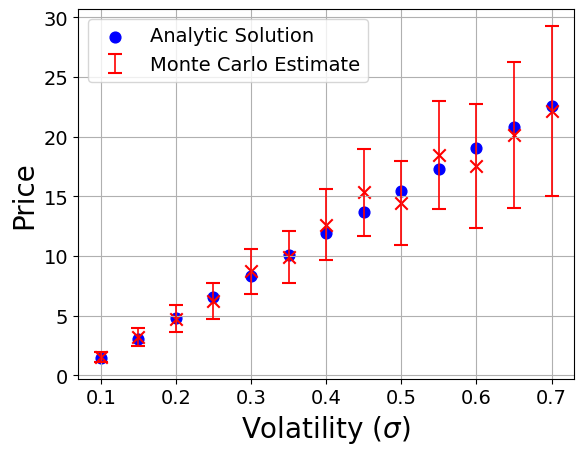

In [149]:
## Verifying MC method correctly prices European calls and puts3
call_option_prices_MC = {}
call_option_CI = {}
put_option_prices_MC = {}
option_prices_analytic = {}
S0 = 90; T = 1; K = 100; r = 0.04; sigma = 0.15; N = 1000; M = 1000
sigma_range = np.linspace(0.1, 0.7, 13)
for sigma in sigma_range:
    call_option_prices_MC[sigma], call_option_CI[sigma], _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                                   option_type='european', antithetic=True)
    option_prices_analytic[sigma] = eu_option_price(S0, K, T, r, sigma)
call_options_analytic = [option_prices_analytic[sigma][0] for sigma in sigma_range]
call_options_MC = [call_option_prices_MC[sigma] for sigma in sigma_range]
call_options_CI_lower = [call_option_CI[sigma][0] for sigma in sigma_range]
call_options_CI_upper = [call_option_CI[sigma][1] for sigma in sigma_range]
call_options_CI = np.array(call_options_CI_upper) - np.array(call_options_CI_lower)

plt.scatter(sigma_range, call_options_analytic, color='blue', marker='o', 
            label='Analytic Solution', s=60)
plt.errorbar(sigma_range, call_options_MC, yerr=call_options_CI, fmt='none', color='red', 
             capsize=5, capthick=1.5, elinewidth=1.2, label="Monte Carlo Estimate")
plt.scatter(sigma_range, call_options_MC, color='red', marker='x', s=80)


plt.xlabel("Volatility ($\sigma$)", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)
# plt.savefig('report/graphics/validation_mc_european_call_vol.png', bbox_inches='tight', dpi=300)
plt.show()

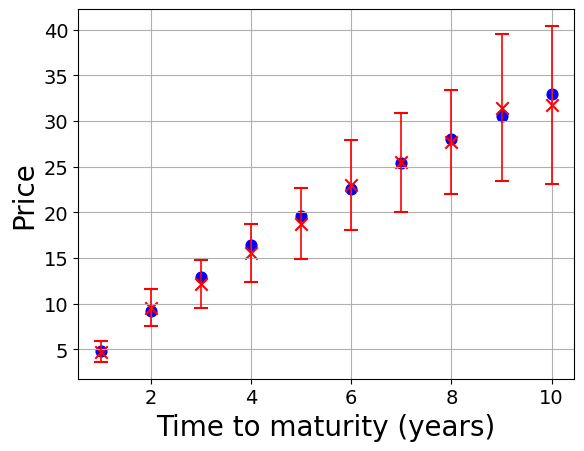

In [150]:
## Verifying geometric Brownian motions and v stack works.
call_option_prices_MC = {}
call_option_CI = {}
option_prices_analytic = {}
S0 = 90; T = 1; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 1000
T_range = np.linspace(1, 10, 10)
for T in T_range:
    call_option_prices_MC[T], call_option_CI[T], _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                                   option_type='european', antithetic=True)
    option_prices_analytic[T] = eu_option_price(S0, K, T, r, sigma)
call_options_analytic = [option_prices_analytic[T][0] for T in T_range]
call_options_MC = [call_option_prices_MC[T] for T in T_range]
call_options_CI_lower = [call_option_CI[T][0] for T in T_range]
call_options_CI_upper = [call_option_CI[T][1] for T in T_range]
call_options_CI = np.array(call_options_CI_upper) - np.array(call_options_CI_lower)

plt.scatter(T_range, call_options_analytic, color='blue', marker='o', 
            label='Analytic Solution', s=60)
plt.errorbar(T_range, call_options_MC, yerr=call_options_CI, fmt='none', color='red', 
             capsize=5, capthick=1.5, elinewidth=1.2, label="Monte Carlo Estimate")
plt.scatter(T_range, call_options_MC, color='red', marker='x', s=80)

plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Time to maturity (years)", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.grid(True)
# plt.savefig('report/graphics/validation_mc_european_call_T.png', bbox_inches='tight', dpi=300)
plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_35021/3333729160.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Volatility ($\sigma$)", fontsize=20)


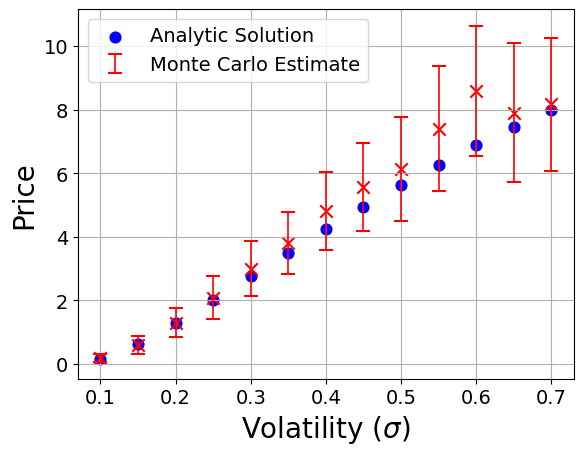

In [151]:
## Verifying MC method correctly prices European calls and puts3
call_option_prices_MC = {}
call_option_CI = {}
put_option_prices_MC = {}
option_prices_analytic = {}
S0 = 90; T = 1; K = 100; r = 0.04; sigma = 0.15; N = 1000; M = 1000
sigma_range = np.linspace(0.1, 0.7, 13)
for sigma in sigma_range:
    call_option_prices_MC[sigma], call_option_CI[sigma], _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                                   option_type='geometric', antithetic=True)
    option_prices_analytic[sigma] = geometric_asian_option_price(S0, K, T, r, sigma)
call_options_analytic = [option_prices_analytic[sigma][0] for sigma in sigma_range]
call_options_MC = [call_option_prices_MC[sigma] for sigma in sigma_range]
call_options_CI_lower = [call_option_CI[sigma][0] for sigma in sigma_range]
call_options_CI_upper = [call_option_CI[sigma][1] for sigma in sigma_range]
call_options_CI = np.array(call_options_CI_upper) - np.array(call_options_CI_lower)

plt.scatter(sigma_range, call_options_analytic, color='blue', marker='o', 
            label='Analytic Solution', s=60)
plt.errorbar(sigma_range, call_options_MC, yerr=call_options_CI, fmt='none', color='red', 
             capsize=5, capthick=1.5, elinewidth=1.2, label="Monte Carlo Estimate")
plt.scatter(sigma_range, call_options_MC, color='red', marker='x', s=80)


plt.xlabel("Volatility ($\sigma$)", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)
# plt.savefig('report/graphics/validation_mc_european_call_vol.png', bbox_inches='tight', dpi=300)
plt.show()

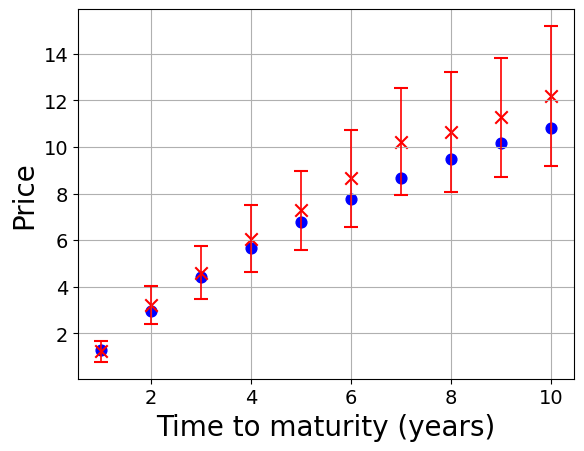

In [152]:
## Verifying geometric Brownian motions and v stack works.
call_option_prices_MC = {}
call_option_CI = {}
option_prices_analytic = {}
S0 = 90; T = 1; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 1000
T_range = np.linspace(1, 10, 10)
for T in T_range:
    call_option_prices_MC[T], call_option_CI[T], _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                                   option_type='geometric', antithetic=True)
    option_prices_analytic[T] = geometric_asian_option_price(S0, K, T, r, sigma)
call_options_analytic = [option_prices_analytic[T][0] for T in T_range]
call_options_MC = [call_option_prices_MC[T] for T in T_range]
call_options_CI_lower = [call_option_CI[T][0] for T in T_range]
call_options_CI_upper = [call_option_CI[T][1] for T in T_range]
call_options_CI = np.array(call_options_CI_upper) - np.array(call_options_CI_lower)

plt.scatter(T_range, call_options_analytic, color='blue', marker='o', 
            label='Analytic Solution', s=60)
plt.errorbar(T_range, call_options_MC, yerr=call_options_CI, fmt='none', color='red', 
             capsize=5, capthick=1.5, elinewidth=1.2, label="Monte Carlo Estimate")
plt.scatter(T_range, call_options_MC, color='red', marker='x', s=80)

plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Time to maturity (years)", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.grid(True)
# plt.savefig('report/graphics/validation_mc_european_call_T.png', bbox_inches='tight', dpi=300)
plt.show()

In [86]:
geometric_asian_option_price(90, 100, 10, 0.04, 0.15)

(np.float64(9.64818103219613), np.float64(5.7064654474631675))

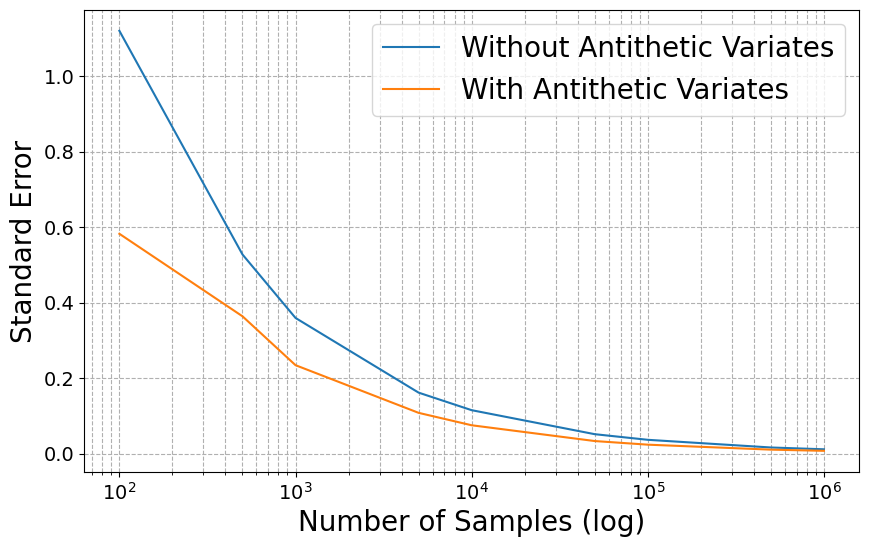

In [153]:
## Now I want to verify the effect of antithetic variates on convergence

S0=100; K=100; T=1; r=0.05; sigma=0.15; N=100
M_range = [10**2, 500, 10**3, 5000, 10**4, 50000, 10**5, 500000, 10**6]


se_no_antithetic = []
se_antithetic = []

np.random.seed(42)

for M in M_range:
    _, _, se_na = MC_call_options(S0, K, T, r, sigma, N, M, antithetic=False)
    _, _, se_a  = MC_call_options(S0, K, T, r, sigma, N, M, antithetic=True)
    se_no_antithetic.append(se_na)
    se_antithetic.append(se_a)


plt.figure(figsize=(10, 6))
plt.plot(M_range, se_no_antithetic, label='Without Antithetic Variates')
plt.plot(M_range, se_antithetic, label='With Antithetic Variates')
plt.xscale('log')
plt.xlabel("Number of Samples (log)", fontsize=20)
plt.ylabel("Standard Error", fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True, which="both", ls="--")
# plt.savefig('report/graphics/stderr_antithetic.png', bbox_inches='tight', dpi=300)
plt.show()

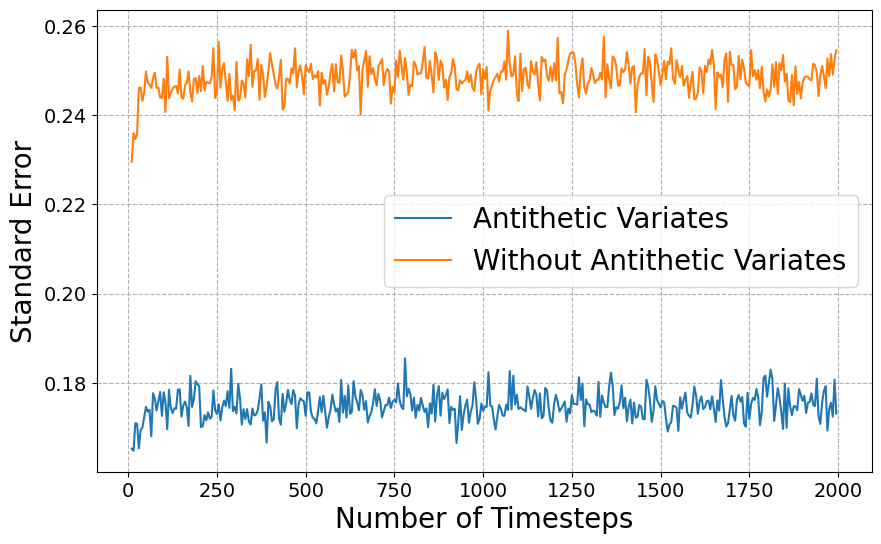

In [154]:
S0 = 100      
K = 100       
T = 2         
r = 0.05      
sigma = 0.2   
N = 100       
M= 10000
# Range of total simulation trials (must be even for antithetic)
N_values = np.arange(10, 2000, 5)

# Use the Black–Scholes price as the "true" price.
true_price = eu_call_price(S0, K, T, r, sigma)

se_antithetic = []
se_no_antithetic = []

# For reproducibility
# np.random.seed(42)

for N in N_values:
    _, _, se_a = MC_call_options(S0, K, T, r, sigma, N, M, option_type='european', antithetic=True)
    _, _, se_no_a  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='european', antithetic=False)
    se_antithetic.append(se_a)
    se_no_antithetic.append(se_no_a)



plt.figure(figsize=(10, 6))
plt.plot(N_values, se_antithetic, label='Antithetic Variates')
plt.plot(N_values, se_no_antithetic, label='Without Antithetic Variates')

plt.tick_params(axis='both', labelsize=14)
plt.xlabel("Number of Timesteps", fontsize=20)
plt.ylabel("Standard Error", fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, which="both", ls="--")
# plt.savefig("report/graphics/stderr_antithetic_with_n.png", bbox_inches='tight', dpi=300)
plt.show()

20
40
60
80
100
120
140
160
180
200
220
240
260
280


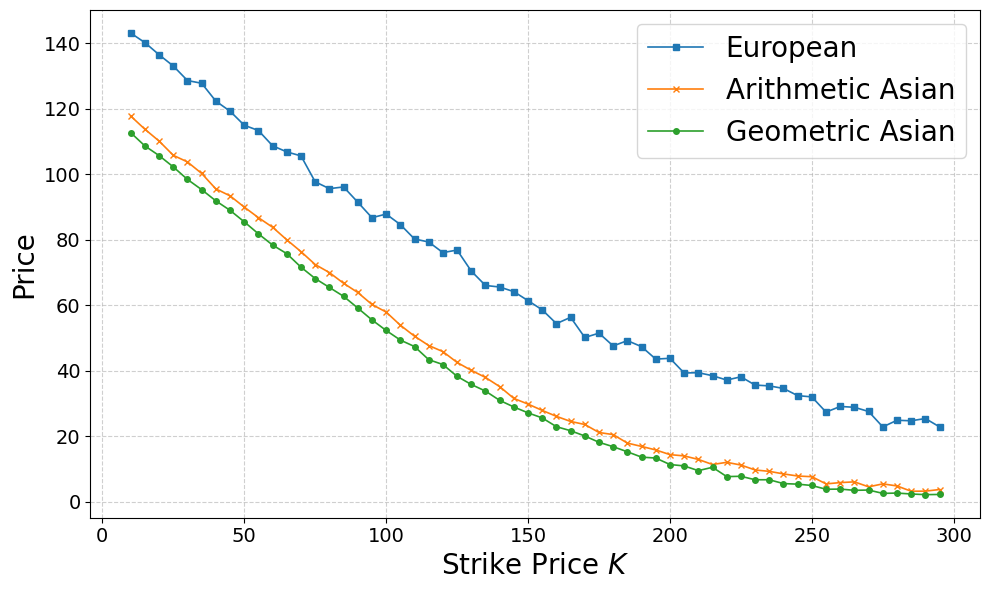

In [155]:
## Plotting varying Asian and geometric options with varying strike
call_geometric = []
call_arithmetic = []
call_european = []
S0 = 150; T = 10; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 2000
K_range = np.arange(10, 300, 5)
for K in K_range:
    if K % 20 == 0:
        print(K)
    call_price_arithmetic, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='arithmetic', antithetic=True)
    call_price_geometric, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='geometric', antithetic=True)
    call_price_european, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='european', antithetic=True)
    call_geometric.append(call_price_geometric)
    call_arithmetic.append(call_price_arithmetic)
    call_european.append(call_price_european)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, call_european, 's-', label='European', linewidth=1.2, markersize=4)
plt.plot(K_range, call_arithmetic, 'x-', label='Arithmetic Asian', linewidth=1.2, markersize=4)
plt.plot(K_range, call_geometric, 'o-', label='Geometric Asian', linewidth=1.2, markersize=4)
plt.xlabel('Strike Price $K$', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('report/graphics/arithmetic_call_prices_K.png', bbox_inches='tight', dpi=300)
plt.show()

20
40
60
80
100
120
140
160
180
200
220
240
260
280


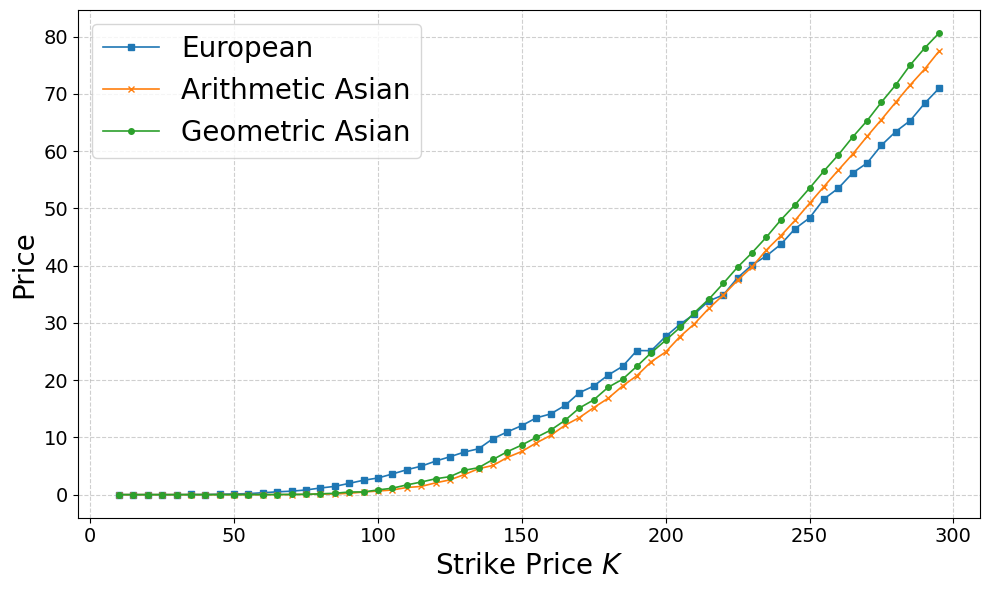

In [156]:
## Plotting varying Asian and geometric options with varying strike
put_geometric = []
put_arithmetic = []
put_european = []
S0 = 150; T = 10; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 2000
K_range = np.arange(10, 300, 5)
for K in K_range:
    if K % 20 == 0:
        print(K)
    put_price_arithmetic, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='arithmetic', antithetic=True)
    put_price_geometric, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='geometric', antithetic=True)
    put_price_european, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='european', antithetic=True)
    put_geometric.append(put_price_geometric)
    put_arithmetic.append(put_price_arithmetic)
    put_european.append(put_price_european)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(K_range, put_european, 's-', label='European', linewidth=1.2, markersize=4)
plt.plot(K_range, put_arithmetic, 'x-', label='Arithmetic Asian', linewidth=1.2, markersize=4)
plt.plot(K_range, put_geometric, 'o-', label='Geometric Asian', linewidth=1.2, markersize=4)
plt.xlabel('Strike Price $K$', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
# plt.savefig('report/graphics/arithmetic_put_prices_K.png', bbox_inches='tight', dpi=300)
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_35021/3477842026.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Volatility $\sigma$', fontsize=20)


0.1
0.2


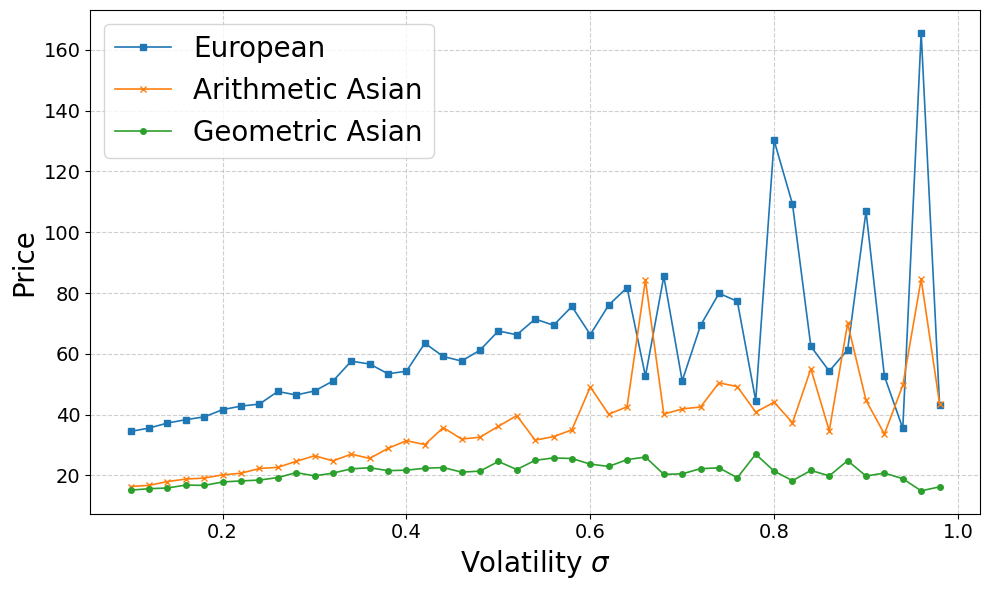

In [157]:
## Plotting varying Asian and geometric options with varying strike
call_geometric = []
call_arithmetic = []
call_european = []
S0 = 100; T = 10; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 2500
sigma_range = np.arange(0.1, 1, 0.02)
for sigma in sigma_range:
    if sigma % 0.05 == 0:
        print(sigma)
    call_price_arithmetic, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='arithmetic', antithetic=True)
    call_price_geometric, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='geometric', antithetic=True)
    call_price_european, _, _ = MC_call_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='european', antithetic=True)
    call_geometric.append(call_price_geometric)
    call_arithmetic.append(call_price_arithmetic)
    call_european.append(call_price_european)

plt.figure(figsize=(10, 6))
plt.plot(sigma_range, call_european, 's-', label='European', linewidth=1.2, markersize=4)
plt.plot(sigma_range, call_arithmetic, 'x-', label='Arithmetic Asian', linewidth=1.2, markersize=4)
plt.plot(sigma_range, call_geometric, 'o-', label='Geometric Asian', linewidth=1.2, markersize=4)
plt.xlabel('Volatility $\sigma$', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('report/graphics/arithmetic_call_prices_sigma.png', bbox_inches='tight', dpi=300)
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_35021/163868756.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Volatility $\sigma$', fontsize=20)


0.1
0.2


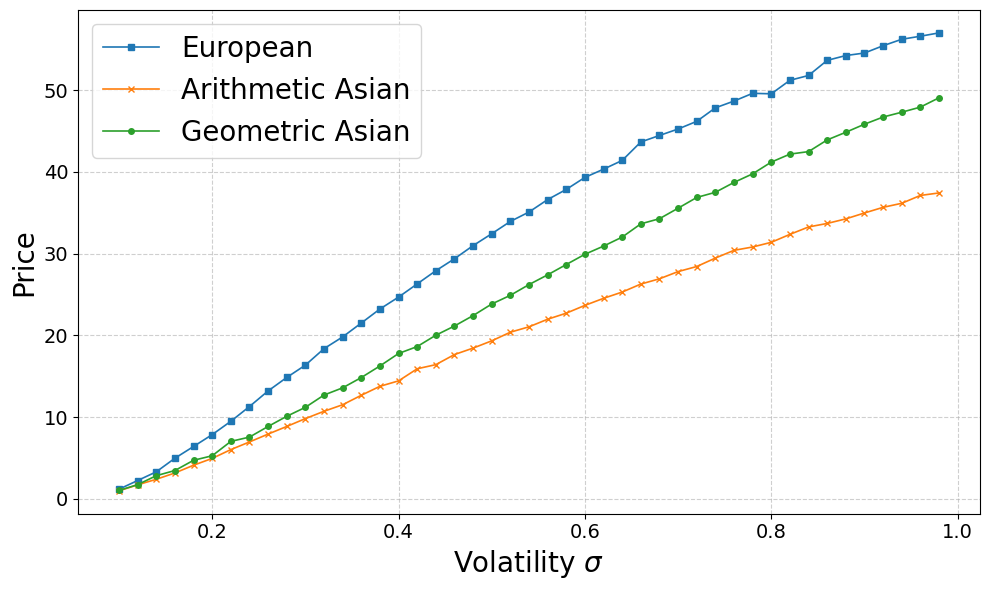

In [158]:
## Plotting varying Asian and geometric options with varying strike
put_geometric = []
put_arithmetic = []
put_european = []
S0 = 100; T = 10; K = 100; r = 0.04; sigma = 0.2; N = 1000; M = 2500
sigma_range = np.arange(0.1, 1, 0.02)
for sigma in sigma_range:
    if sigma % 0.05 == 0:
        print(sigma)
    put_price_arithmetic, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='arithmetic', antithetic=True)
    put_price_geometric, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='geometric', antithetic=True)
    put_price_european, _, _ = MC_put_options(S0, K, T, r, sigma, N, M, 
                                                  option_type='european', antithetic=True)
    put_geometric.append(put_price_geometric)
    put_arithmetic.append(put_price_arithmetic)
    put_european.append(put_price_european)

plt.figure(figsize=(10, 6))
plt.plot(sigma_range, put_european, 's-', label='European', linewidth=1.2, markersize=4)
plt.plot(sigma_range, put_arithmetic, 'x-', label='Arithmetic Asian', linewidth=1.2, markersize=4)
plt.plot(sigma_range, put_geometric, 'o-', label='Geometric Asian', linewidth=1.2, markersize=4)
plt.xlabel('Volatility $\sigma$', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('report/graphics/arithmetic_put_prices_sigma.png', bbox_inches='tight', dpi=300)
plt.show()

500
1000
5000
10000
50000
100000
500000
1000000


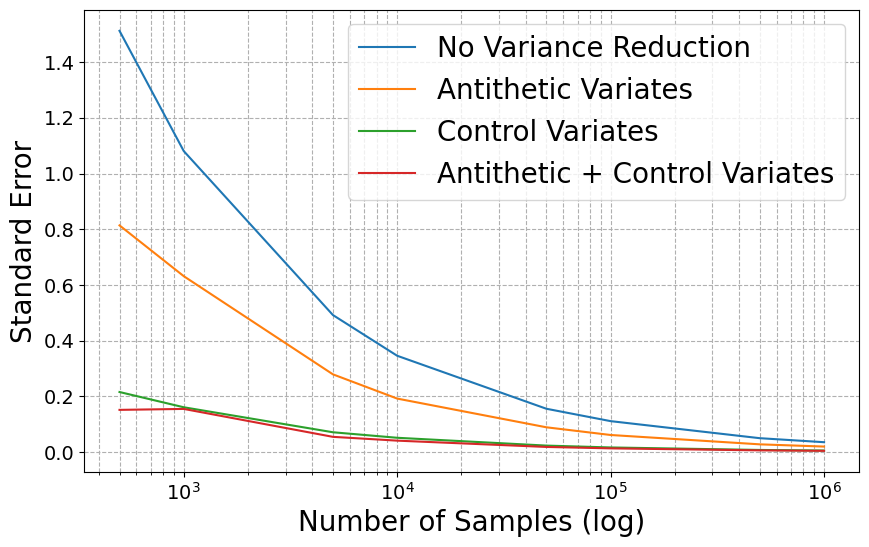

In [170]:
S0=100; K=100; T=10; r=0.05; sigma=0.15; N=100
M_range = [500, 10**3, 5000, 10**4, 50000, 10**5, 500000, 10**6]


se_mc_results = []
se_av_results = []
se_cv_results = []
se_av_cv_results = []

np.random.seed(42)

for M in M_range:
    print(M)
    _, _, se_mc = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                  antithetic=False, control_variate=False)
    _, _, se_av  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic',
                                    antithetic=True, control_variate=False)
    _, _, se_cv  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                   antithetic=False, control_variate=True)
    _, _, se_av_cv  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                      antithetic=True, control_variate=True)

    se_mc_results.append(se_mc)
    se_av_results.append(se_av)
    se_cv_results.append(se_cv)
    se_av_cv_results.append(se_av_cv)


plt.figure(figsize=(10, 6))
plt.plot(M_range, se_mc_results, label='No Variance Reduction')
plt.plot(M_range, se_av_results, label='Antithetic Variates')
plt.plot(M_range, se_cv_results, label='Control Variates')
plt.plot(M_range, se_av_cv_results, label='Antithetic + Control Variates')
plt.xscale('log')
plt.xlabel("Number of Samples (log)", fontsize=20)
plt.ylabel("Standard Error", fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True, which="both", ls="--")
plt.savefig('report/graphics/stderr_av+cv_M.png', bbox_inches='tight', dpi=300)
plt.show()

200
400
600
800
1000
1200
1400
1600
1800


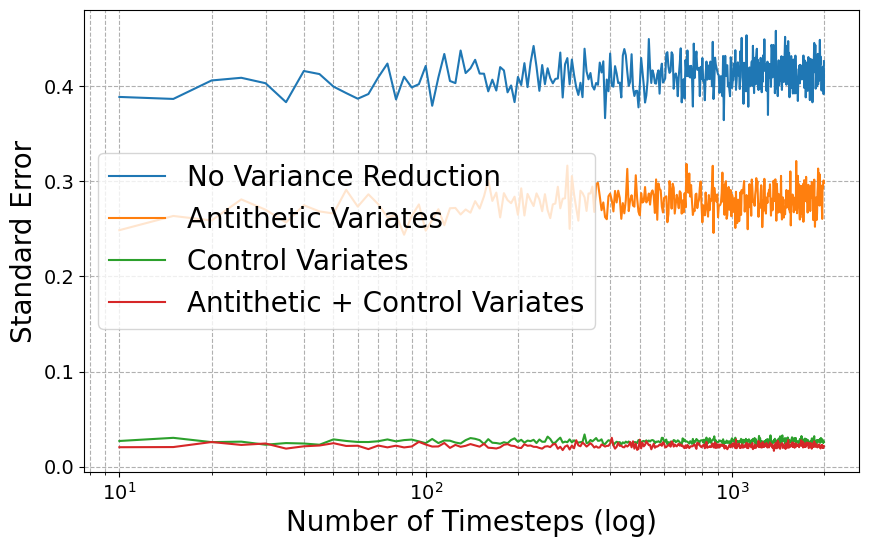

In [171]:
S0 = 100      
K = 100       
T = 2         
r = 0.05      
sigma = 0.2   
N = 100       
M= 1000
# Range of total simulation trials (must be even for antithetic)
N_values = np.arange(10, 2000, 5)

se_mc_results = []
se_av_results = []
se_cv_results = []
se_av_cv_results = []

np.random.seed(42)

for N in N_values:
    if N % 200 == 0:
        print(N)
    _, _, se_mc = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                  antithetic=False, control_variate=False)
    _, _, se_av  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                   antithetic=True, control_variate=False)
    _, _, se_cv  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                   antithetic=False, control_variate=True)
    _, _, se_av_cv  = MC_call_options(S0, K, T, r, sigma, N, M, option_type='arithmetic', 
                                      antithetic=True, control_variate=True)

    se_mc_results.append(se_mc)
    se_av_results.append(se_av)
    se_cv_results.append(se_cv)
    se_av_cv_results.append(se_av_cv)


plt.figure(figsize=(10, 6))
plt.plot(N_values, se_mc_results, label='No Variance Reduction')
plt.plot(N_values, se_av_results, label='Antithetic Variates')
plt.plot(N_values, se_cv_results, label='Control Variates')
plt.plot(N_values, se_av_cv_results, label='Antithetic + Control Variates')
plt.xscale('log')
plt.xlabel("Number of Timesteps (log)", fontsize=20)
plt.ylabel("Standard Error", fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True, which="both", ls="--")
plt.savefig('report/graphics/stderr_av+cv_N.png', bbox_inches='tight', dpi=300)
plt.show()